### ISC Within Languages

#### Import Modules

In [1]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys, os, nilearn
sys.path.append("..")
from lpp_utils import *
from nilearn import datasets, plotting
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm, pearsonr, zscore


#### Open the Mask

In [2]:
file = open('../../data_lpp/fmri_data/other/all293_masker_pickled.obj', 'rb') 
all293_masker_reopened = pickle.load(file)
file.close();
all293_masker_reopened

NiftiLabelsMasker(detrend=True, high_pass=0.01,
                  labels_img='../../data_lpp/fmri_data/other/allcombined.nii',
                  low_pass=0.12, standardize=True, t_r=2.0)

#### Load data, perform basic ISC

For illustrative purposes for the English listeners and section1 only

(291, 293, 50)
0.5079655836237076
Assuming 50 subjects with 271 time points and 293 voxel(s) or ROI(s).


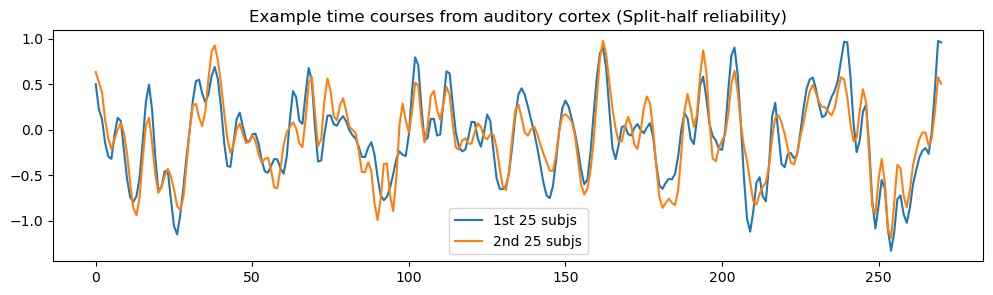

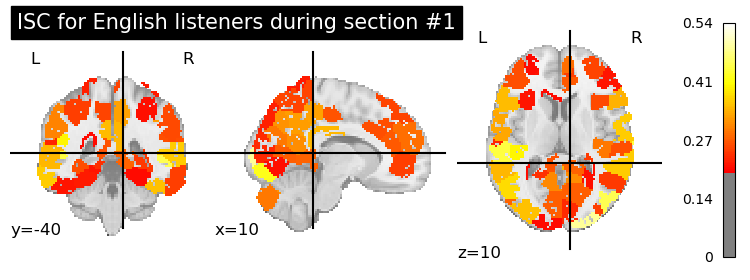

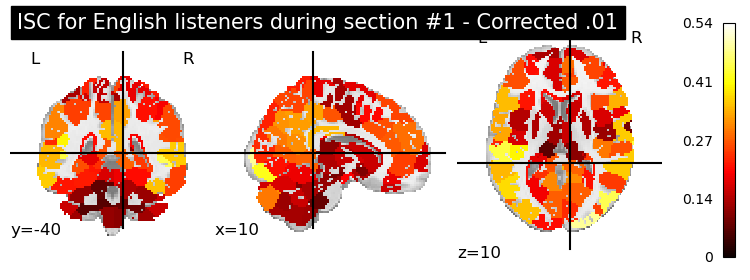

In [3]:
path = "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppEN-run-01_resampled291.npy"
curr_data = np.load(path)
print(curr_data.shape)

transient_cut = 10


# Time course split-half plot for auditory cortex 
test_region = 62
m1 = np.mean(curr_data[transient_cut:-transient_cut,:,:25], axis=2)
m2 = np.mean(curr_data[transient_cut:-transient_cut,:,25:], axis=2)
print(np.corrcoef(m1[test_region,:], m2[test_region,:])[0,1])

plt.figure(figsize = (12,3))
plt.plot(m1[:,test_region], label = '1st 25 subjs');
plt.plot(m2[:,test_region], label = '2nd 25 subjs');
plt.title('Example time courses from auditory cortex (Split-half reliability)')
plt.legend();

# whole brain ISC
res = lpp_isc(curr_data[transient_cut:-transient_cut,:,:], summary_statistic = np.mean)
curr_img = all293_masker_reopened.inverse_transform(res)
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                               cut_coords = (10, -40, 10),
                               threshold = 0.2, 
                               title = 'ISC for English listeners during section #1');


# Phase randomization using pairwise approach (takes a couple minutes)
observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], 
                                           pairwise=True,
                                           summary_statistic='median',
                                           n_shifts=1000)

q = multipletests(p, method='fdr_by')[1]
corrected = q[np.newaxis, :] < .01
corrected_res = np.zeros((1,293))
corrected_res[corrected] = res[corrected]

curr_img = all293_masker_reopened.inverse_transform(corrected_res)
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                               cut_coords = (10, -40, 10),
                               #threshold = 0.2, 
                               title = 'ISC for English listeners during section #1 - Corrected .01');


#### Generalize ISC calculation to multiple runs and across all languages (english, french, chinese)

Note: computing here a pairwise ISC. Typically, the ind2group procedure is to be preferred, but with unequal sample sizes (50 English, 27 French, 33 Chinese), the results are better comparable this way. We will later use a statistical thresholding procedure that helps als running the alternative analysis.

In [ ]:
n_runs = 9
transient_cut = 10
stats_threshold = 0.01
n_perm = 1000

lenghts = [291, 315, 338, 308, 283, 371, 340, 293, 368]

isc_english = np.zeros((293,n_runs))
isc_french  = np.zeros((293,n_runs))
isc_chinese = np.zeros((293,n_runs))

isc_english_corrected = np.zeros((293,n_runs))
isc_french_corrected  = np.zeros((293,n_runs))
isc_chinese_corrected = np.zeros((293,n_runs))

for curr_run in range(n_runs):
    # English
    curr_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-0" + str(curr_run+1) + "resampled" + str(lenghts[curr_run])+".npy")
    observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], pairwise=True,summary_statistic='median',n_shifts=n_perm)
    isc_english[:, curr_run] = observed
    q = multipletests(p, method='fdr_by')[1]
    corrected = q  < stats_threshold
    corrected_res = np.zeros(observed.shape[0])
    corrected_res[corrected] = observed[corrected]
    isc_english_corrected[:, curr_run]  = corrected_res
    
    #'''
    # French
    curr_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-0"  + str(curr_run+1) + "resampled" + str(lenghts[curr_run])+".npy")
    observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], pairwise=True,summary_statistic='median',n_shifts=n_perm)
    isc_french[:, curr_run] = observed
    q = multipletests(p, method='fdr_by')[1]
    corrected = q  < stats_threshold
    corrected_res = np.zeros(observed.shape[0])
    corrected_res[corrected] = observed[corrected]
    isc_french_corrected[:, curr_run]  = corrected_res
    
    # Chinese
    curr_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-0"  + str(curr_run+1) + "resampled" + str(lenghts[curr_run])+".npy")
    observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], pairwise=True,summary_statistic='median',n_shifts=n_perm)
    isc_chinese[:, curr_run] = observed
    q = multipletests(p, method='fdr_by')[1]
    corrected = q  < stats_threshold
    corrected_res = np.zeros(observed.shape[0])
    corrected_res[corrected] = observed[corrected]
    isc_chinese_corrected[:, curr_run]  = corrected_res #'''

In [ ]:
m_isc_fr = np.mean(isc_french , axis = 1)
m_isc_cn = np.mean(isc_chinese, axis = 1)
m_isc_en = np.mean(isc_english, axis = 1)

m_isc_corrected_fr = np.mean(isc_french_corrected , axis = 1)
m_isc_corrected_cn = np.mean(isc_chinese_corrected, axis = 1)
m_isc_corrected_en = np.mean(isc_english_corrected, axis = 1)

val_v_max = 0.15
slices_to_plot = [-50, 5, 50]

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_fr, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Blues',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,
                            #title = 'ISC among French Listeners',
                      );

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_cn, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Oranges',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,
                            #title = 'ISC among Chinese Listeners',
                      );

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_en, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greens',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,
                            #title = 'ISC among English Listeners',
                      );



plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_fr, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Blues',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,
                            #title = 'ISC among French Listeners',
                      );

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_cn, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Oranges',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,
                            #title = 'ISC among Chinese Listeners',
                      );

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_en, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greens',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,
                            #title = 'ISC among English Listeners',
                      );

In [ ]:
f = plt.figure(figsize = (15,5));
ax = f.add_subplot(1,3,1);
ax.scatter(m_isc_corrected_fr, m_isc_corrected_cn, color = 'blue', alpha = .3); 
ax.set_xlim(0,.25);
ax.set_ylim(0,.25);
ax.set_xlabel('French')
ax.set_ylabel('Chinese')

ax = f.add_subplot(1,3,2);
ax.scatter(m_isc_corrected_en, m_isc_corrected_cn, color = 'green', alpha = .3);
ax.set_xlim(0,.25);
ax.set_ylim(0,.25);
ax.set_xlabel('English')
ax.set_ylabel('Chinese')

ax = f.add_subplot(1,3,3);
ax.scatter(m_isc_corrected_en, m_isc_corrected_fr, color = 'red', alpha = .3);
ax.set_xlim(0,.25);
ax.set_ylim(0,.25);
ax.set_xlabel('English')
ax.set_ylabel('French')


df = pd.DataFrame(np.stack((m_isc_corrected_fr, m_isc_corrected_cn, m_isc_corrected_en)).T, columns = ['French', 'Chinese', 'English'])
df.corr()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
#sns.set_style("ticks")
sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});
sns.set_style('ticks')

f, ax = plt.subplots(figsize=(4., 4.));

sns.scatterplot( m_isc_corrected_cn,
                m_isc_corrected_fr,
                marker="o",  
                color = 'black',
                ax=ax)
ax.set_xticks(np.arange(0, 0.26, 0.05)) 
ax.set_xticklabels([])

ax.set_yticks(np.arange(0, 0.26, 0.05)) 
ax.set_yticklabels([])

ax.set_xlim(0,.25);
ax.set_ylim(0,.25);
ax.set_xlabel('Chinese')
ax.set_ylabel('French')
sns.despine(left=False);


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
#sns.set_style("ticks")
sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});
sns.set_style('ticks')

f, ax = plt.subplots(figsize=(4., 4.));

sns.scatterplot(  m_isc_corrected_en,
                m_isc_corrected_cn,
                marker="o",  
                color = 'black',
                ax=ax)
ax.set_xticks(np.arange(0, 0.26, 0.05)) 
ax.set_xticklabels([])

ax.set_yticks(np.arange(0, 0.26, 0.05)) 
ax.set_yticklabels([])

ax.set_xlim(0,.25);
ax.set_ylim(0,.25);
ax.set_xlabel('English')
ax.set_ylabel('Chinese')
sns.despine(left=False);


/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


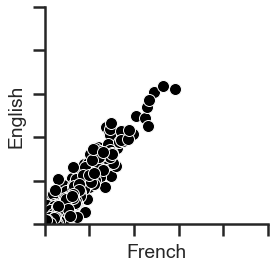

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
#sns.set_style("ticks")
sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});
sns.set_style('ticks')

f, ax = plt.subplots(figsize=(4., 4.));

sns.scatterplot(m_isc_corrected_fr,
                m_isc_corrected_en,
                marker="o",  
                color = 'black',
                ax=ax)
ax.set_xticks(np.arange(0, 0.26, 0.05)) 
ax.set_xticklabels([])

ax.set_yticks(np.arange(0, 0.26, 0.05)) 
ax.set_yticklabels([])

ax.set_xlim(0,.25);
ax.set_ylim(0,.25);
ax.set_xlabel('French')
ax.set_ylabel('English')
sns.despine(left=False);


In [ ]:
ax = plt.axes(projection='3d')
ax.view_init(20, -45)
ax.scatter3D(m_isc_fr, m_isc_cn, m_isc_en);

<Figure size 1008x288 with 0 Axes>

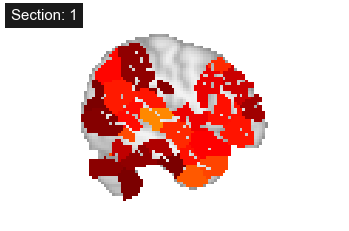

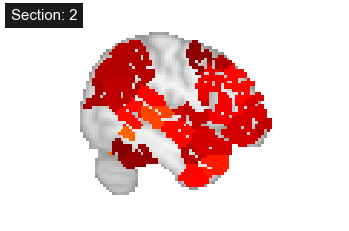

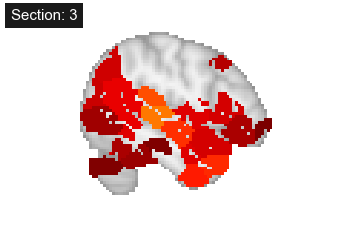

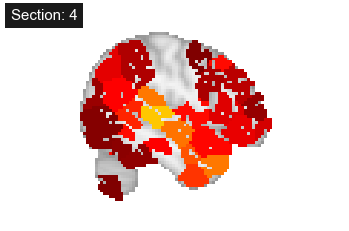

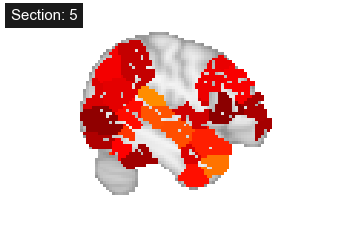

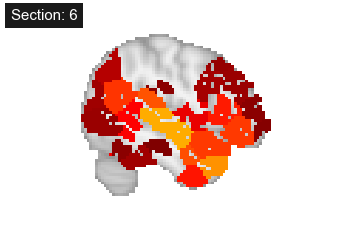

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


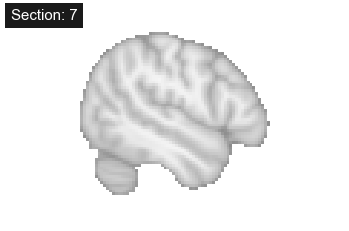

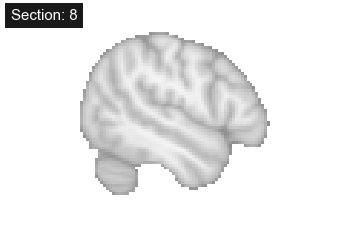

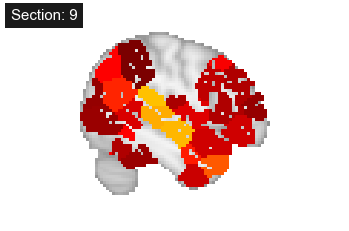

'\nn_runs = 9\nfor n in range(9):\n    ax = f.add_subplot(1,n_runs, n + 1)\n    \n    curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_chinese[:,n], (1, 293)))\n    plotting.plot_stat_map( curr_img, \n                            colorbar     = False, \n                            annotate     = False,\n                            display_mode = "x",\n                            cut_coords   = [x_slice],\n                            threshold    = 0.05,\n                            vmax         = 0.3,\n                            axes         = ax,\n                             );\n    \n    #ax.set_aspect(\'equal\')\n    \nf.subplots_adjust(wspace=0, hspace=0)\nplt.title(\'Chinese\')\n\n#'

In [13]:
f = plt.figure(figsize=(14,4))

x_slice = -50

n_runs = 9
for n in range(n_runs):
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)# f.add_subplot(1,n_runs, n + 1)
    
    curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_french_corrected[:,n], (1, 293)))
    plotting.plot_stat_map( curr_img, 
                            colorbar     = False, 
                            annotate     = False,
                            display_mode = "x",
                            cut_coords   = [x_slice],
                            threshold    = 0.05,
                            vmax         = 0.3,
                            axes         = ax,
                            title = 'Section: ' + str(n+1),
                             );
    plt.show()
    #ax.set_aspect('equal')
    
##f.subplots_adjust(wspace=0, hspace=0)
#plt.title('English')

'''
#f = plt.figure(figsize=(16,4))

n_runs = 9
for n in range(n_runs):
    ax = f.add_subplot(1,n_runs, n + 1)
    
    curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_french[:,n], (1, 293)))
    plotting.plot_stat_map( curr_img, 
                            colorbar     = False, 
                            annotate     = False,
                            display_mode = "x",
                            cut_coords   = [x_slice],
                            threshold    = 0.05,
                            vmax         = 0.3,
                            axes         = ax,
                             );
    
    ax.set_aspect('equal')
    
f.subplots_adjust(wspace=0, hspace=0)
plt.title('French')
'''

###
#f = plt.figure(figsize=(16,4))
'''
n_runs = 9
for n in range(9):
    ax = f.add_subplot(1,n_runs, n + 1)
    
    curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_chinese[:,n], (1, 293)))
    plotting.plot_stat_map( curr_img, 
                            colorbar     = False, 
                            annotate     = False,
                            display_mode = "x",
                            cut_coords   = [x_slice],
                            threshold    = 0.05,
                            vmax         = 0.3,
                            axes         = ax,
                             );
    
    #ax.set_aspect('equal')
    
f.subplots_adjust(wspace=0, hspace=0)
plt.title('Chinese')

#'''

<Figure size 1008x288 with 0 Axes>

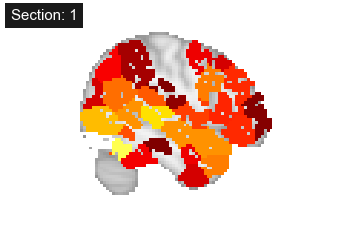

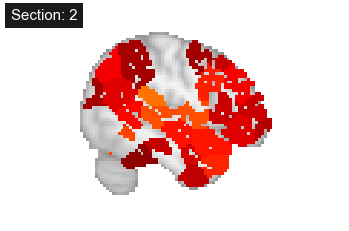

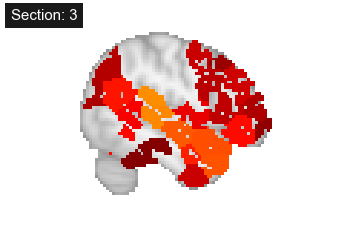

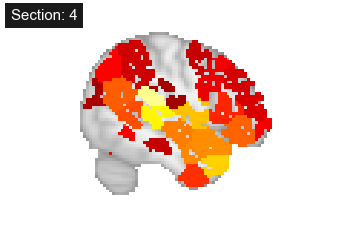

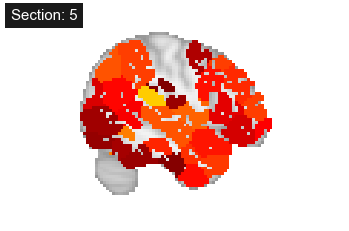

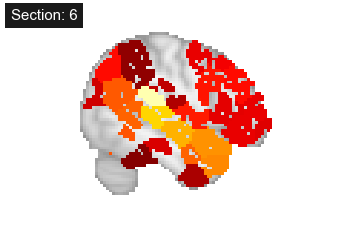

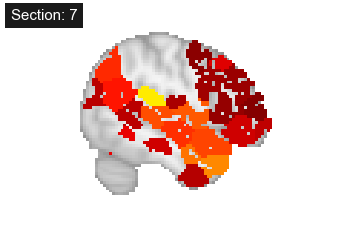

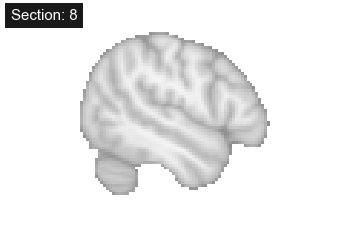

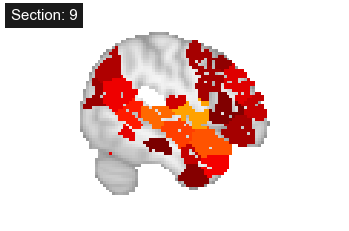

In [14]:
f = plt.figure(figsize=(14,4))

x_slice = -50

n_runs = 9
for n in range(n_runs):
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)# f.add_subplot(1,n_runs, n + 1)
    
    curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_chinese_corrected[:,n], (1, 293)))
    plotting.plot_stat_map( curr_img, 
                            colorbar     = False, 
                            annotate     = False,
                            display_mode = "x",
                            cut_coords   = [x_slice],
                            threshold    = 0.05,
                            vmax         = 0.3,
                            axes         = ax,
                            title = 'Section: ' + str(n+1),
                             );
    plt.show()
    


<Figure size 1008x288 with 0 Axes>

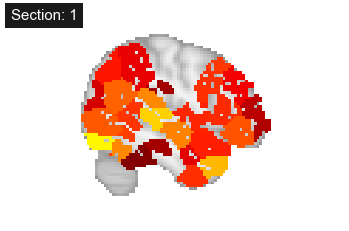

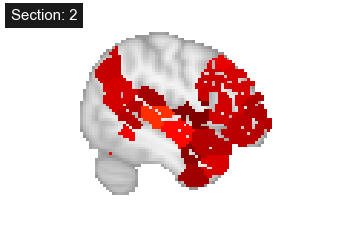

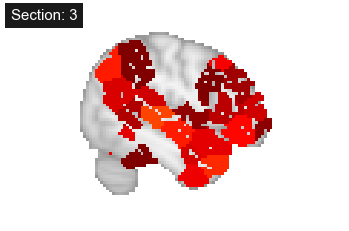

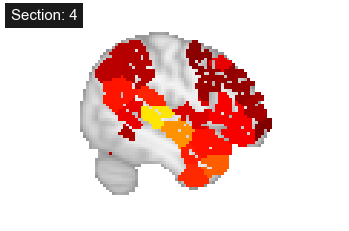

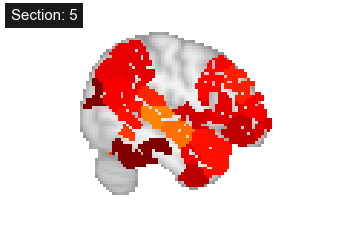

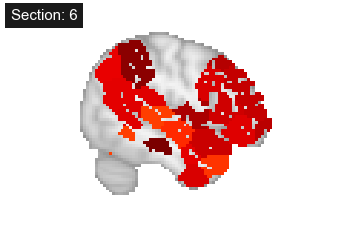

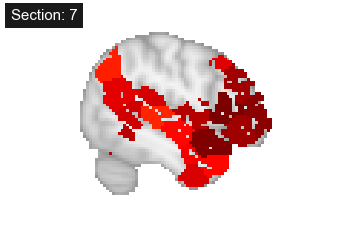

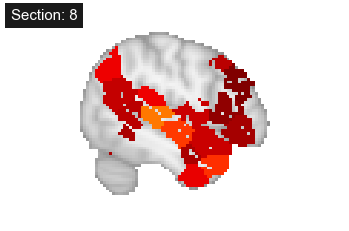

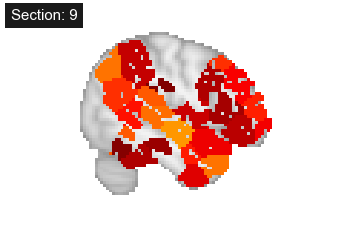

In [15]:
f = plt.figure(figsize=(14,4))

x_slice = -50

n_runs = 9
for n in range(n_runs):
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)# f.add_subplot(1,n_runs, n + 1)
    
    curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_english_corrected[:,n], (1, 293)))
    plotting.plot_stat_map( curr_img, 
                            colorbar     = False, 
                            annotate     = False,
                            display_mode = "x",
                            cut_coords   = [x_slice],
                            threshold    = 0.05,
                            vmax         = 0.3,
                            axes         = ax,
                            title = 'Section: ' + str(n+1),
                             );
    plt.show()
    


In [ ]:
xslice = 55

curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_english[:,0], (1, 293)))
plotting.plot_stat_map( curr_img, 
                        colorbar=True, 
                        annotate = False,
                        display_mode="x",
                        cut_coords= [xslice],
                        threshold = 0.05,
                        vmax = 0.3,
                         );

curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_french[:,0], (1, 293)))
plotting.plot_stat_map( curr_img, 
                        colorbar= False, 
                        annotate = False,
                        display_mode="x",
                        cut_coords= [xslice],
                        threshold = 0.05,
                        vmax = 0.3,
                         );

curr_img = all293_masker_reopened.inverse_transform(np.reshape(isc_chinese[:,0], (1, 293)))
plotting.plot_stat_map( curr_img, 
                        colorbar= False, 
                        annotate = False,
                        display_mode="x",
                        cut_coords = [xslice],
                        threshold = 0.05,
                        vmax = 0.3,
                        #symmetric_cbar = False,
                         );